In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19

import wandb
from wandb.keras import WandbCallback

In [14]:

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

# Dataset inspect
# Read images to variables
size = 224
# X_train, y_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

In [15]:
np.asarray(X_train).shape

(125, 224, 224, 3)

In [30]:
base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
base_model.trainable = False

In [31]:
from keras import Model
import keras
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


inputs = Input(shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
x = vgg16.preprocess_input(inputs)
x = base_model(x)
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                             

In [32]:
checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [33]:


wand_run  = wandb.init(project="baseline_vgg16", entity="bex_team",
           config={"learning_rate" : 0.001,
                   "epochs": 50,
                   "batch_size": 30,
                   "architecture" : "VGG19",
                   "dataset" : "Brain MRI Images for Brain Tumor Detection"})

config = wandb.config


In [34]:
metrics = ['accuracy']

tf.keras.backend.clear_session()

opt = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)#learning_rate=0.0006)
# opt = tf.keras.optimizers.ad(learning_rate=0.00015)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=metrics)

callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val),np.array(y_val)), epochs=config.epochs, batch_size=config.batch_size, verbose=2, callbacks=[callbacks, model_checkpoint_callback, WandbCallback(data_type='image', training_data=(np.array(X_val),np.array(y_val)), labels=CLASSES)])



trained_model_artifact = wandb.Artifact(config.architecture, type="model", description="baseline flatten for vgg16")
trained_model_artifact.add_dir(checkpoint_filepath.parent)
wand_run.log_artifact(trained_model_artifact)


wand_run.join()
wand_run.finish()

Epoch 1/50
5/5 - 7s - loss: 13.0476 - accuracy: 0.5600 - val_loss: 1.5160 - val_accuracy: 0.7619 - 7s/epoch - 1s/step
Epoch 2/50
5/5 - 4s - loss: 4.5119 - accuracy: 0.6080 - val_loss: 1.6746 - val_accuracy: 0.8095 - 4s/epoch - 779ms/step
Epoch 3/50
5/5 - 2s - loss: 1.9851 - accuracy: 0.8640 - val_loss: 3.7370 - val_accuracy: 0.6905 - 2s/epoch - 464ms/step
Epoch 4/50
5/5 - 2s - loss: 1.5843 - accuracy: 0.9040 - val_loss: 2.0985 - val_accuracy: 0.8095 - 2s/epoch - 463ms/step
Epoch 5/50
5/5 - 2s - loss: 0.6232 - accuracy: 0.9440 - val_loss: 5.4768 - val_accuracy: 0.7143 - 2s/epoch - 485ms/step
Epoch 6/50
5/5 - 2s - loss: 0.6770 - accuracy: 0.9200 - val_loss: 3.4432 - val_accuracy: 0.7857 - 2s/epoch - 496ms/step
Epoch 7/50
5/5 - 4s - loss: 0.0733 - accuracy: 0.9840 - val_loss: 1.5403 - val_accuracy: 0.8333 - 4s/epoch - 834ms/step
Epoch 8/50
5/5 - 4s - loss: 0.0080 - accuracy: 0.9920 - val_loss: 1.4159 - val_accuracy: 0.8810 - 4s/epoch - 866ms/step
Epoch 9/50
5/5 - 2s - loss: 0.0060 - accur

wandb: Adding directory to artifact (p:\Python\StudieGrupp3_MLProjekt\notebooks\modelling\model_checkpoint)... Done. 0.6s


accuracy,▁▂▆▆▇███████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▅▁▅▄▆▇▆▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,▂▂█▃▇▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,49
best_val_loss,1.32946
epoch,49
loss,0.0
val_accuracy,0.88095


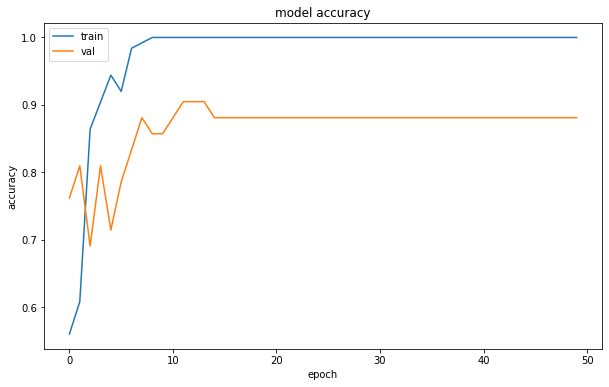

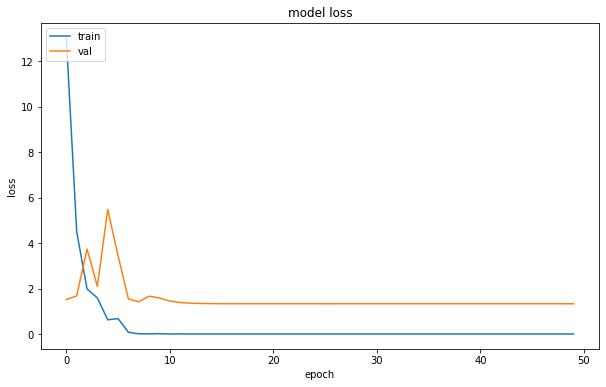

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
CLASS_NAMES = ['yes', 'no']


plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize = (10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

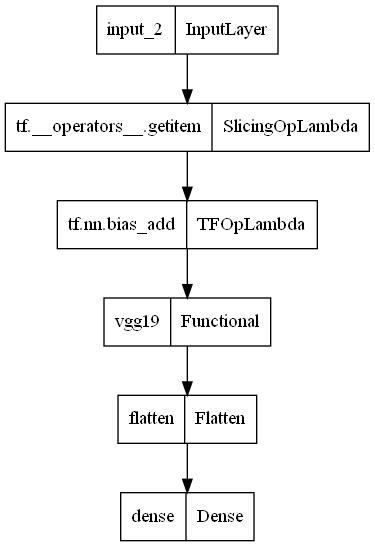

In [29]:
tf.keras.utils.plot_model(model)